#### 생성기의 특정 노드를 끄면 날카로운 (맥시멈 라이클리후드의 결과물처럼 뽀얀 상태에서 어딘가 손생된 듯한) 이미지가 생성될 것인가?

In [27]:
import torch
from torch import nn
import torch.nn.functional as F

class My_Encoder(nn.Module):
    def __init__(self, dim_encoder_output, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.fln = nn.Flatten()
        self.l0 = nn.Linear(784, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x):
        x = self.fln(x)
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, 784)
        self.unfln = nn.Unflatten(1, [1, 28, 28])

    def forward(self, z):
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        x_hat = self.unfln(x_hat)
        return x_hat

    def step_1(self, z):
        h = self.activation(self.l0(z))
        h = self.activation(self.l1(h))
        return h

    def step_2(self, h):
        x_hat = torch.sigmoid(self.l2(h))
        x_hat = self.unfln(x_hat)
        return x_hat


In [12]:
from myAE import Manager

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(2), My_Decoder(2))

def calc_loss(model, x, y, F, device):
    z = model.get_submodule("encoder")(x)
    x_hat = model.get_submodule("decoder")(z)
    loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
    return loss

hist = manager.train(calc_loss, epochs=30)

Now, it is working on cuda:0.


100%|██████████| 30/30 [02:23<00:00,  4.79s/it]


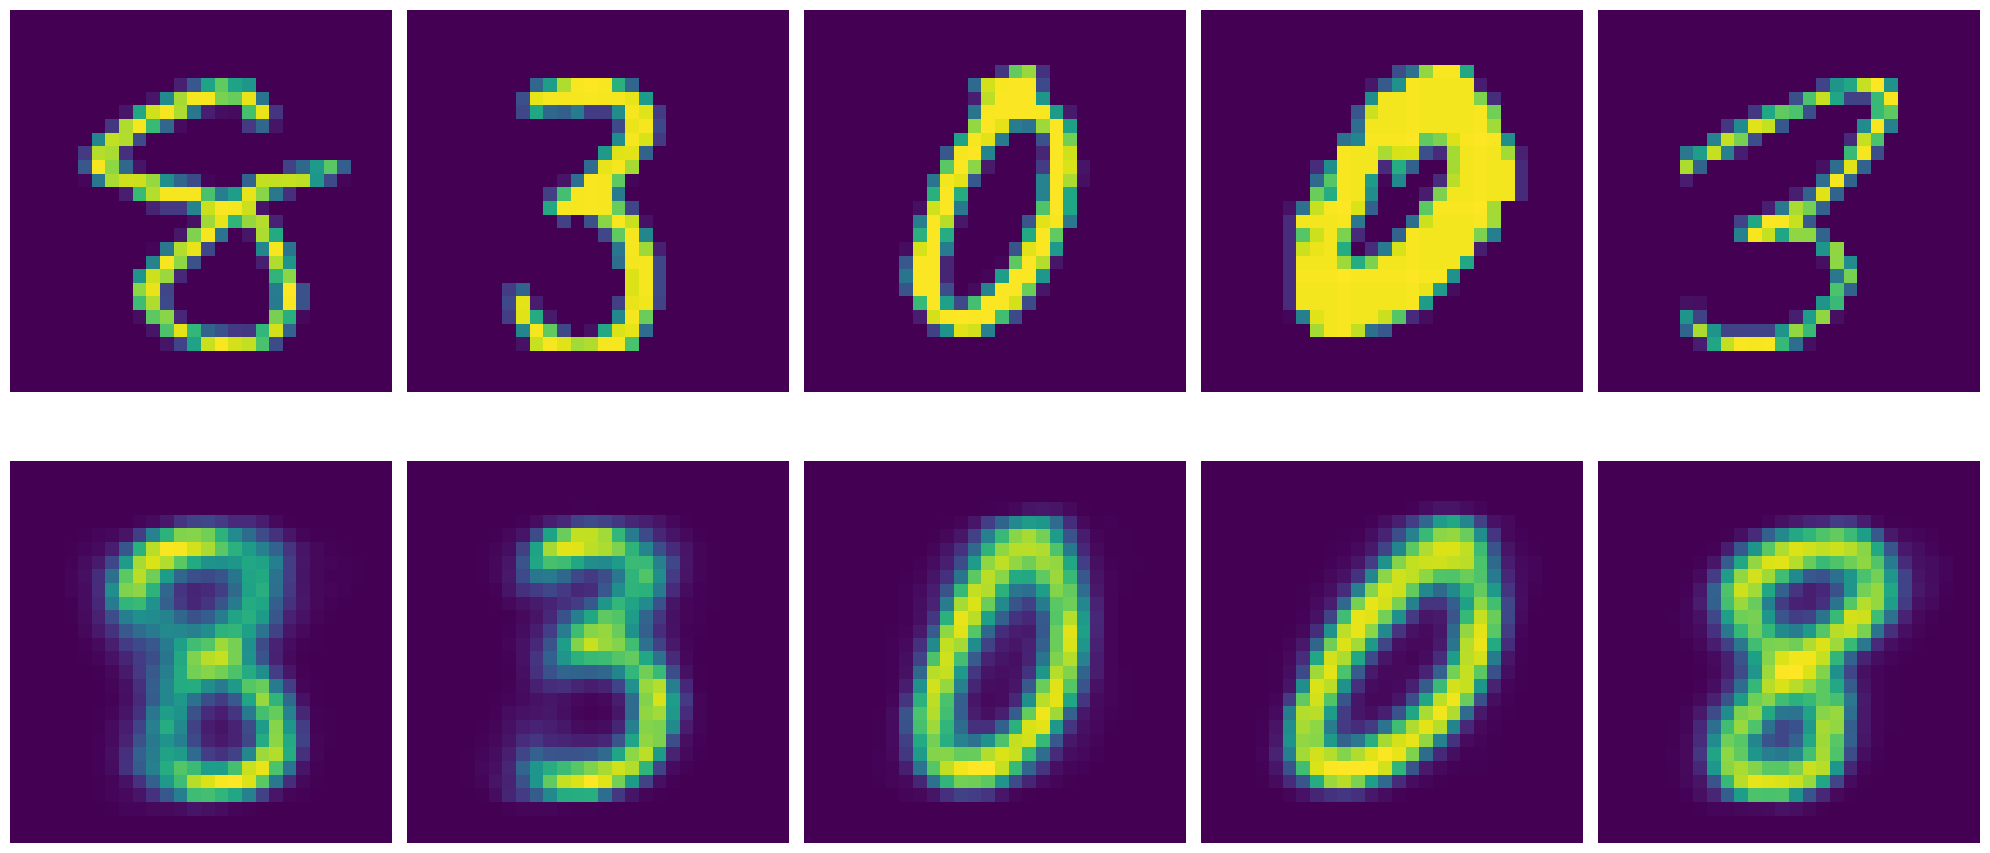

In [13]:
import matplotlib.pyplot as plt

fig, (axs1, axs2) = plt.subplots(nrows=2, ncols=5, figsize=[20, 10])

manager.model.to('cpu')
manager.model.eval()

for x, y in manager.train_dataloader:
    with torch.no_grad():
        x_hats = manager.model(x[:5])
    for ax, img in zip(axs1, x[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs2, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    break
plt.tight_layout()

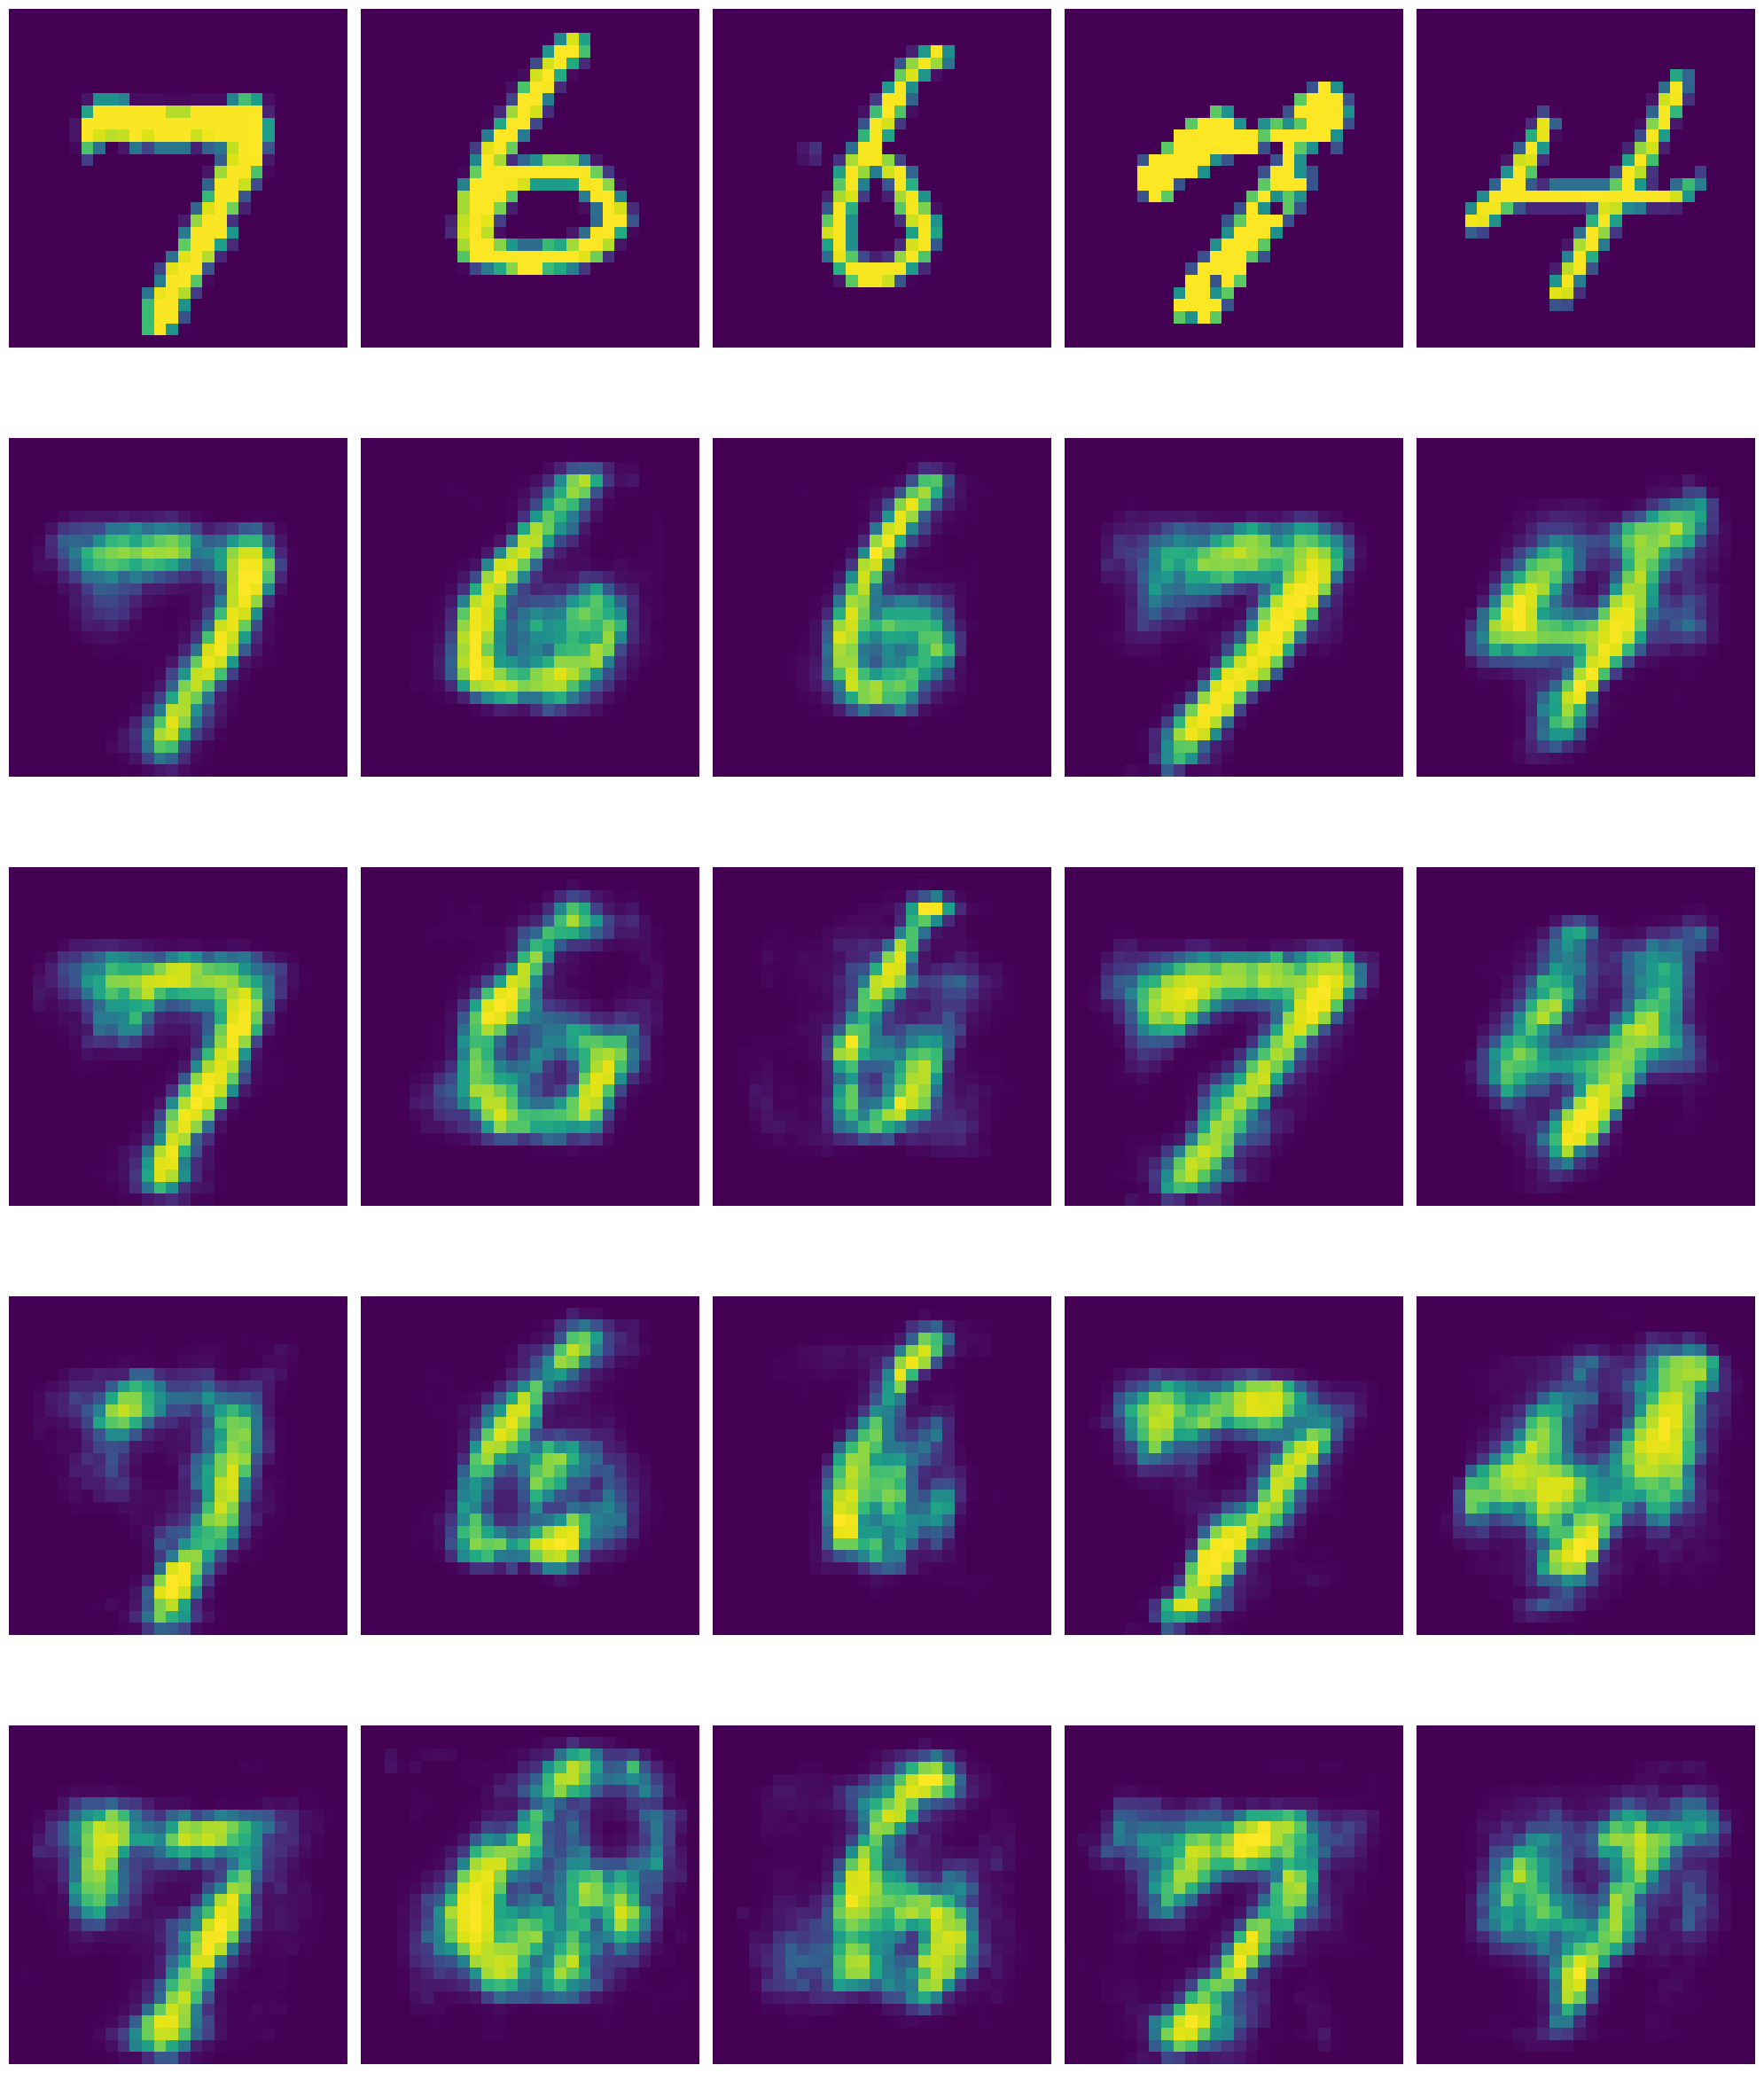

In [26]:
import matplotlib.pyplot as plt

fig, (axs1, axs2, axs3, axs4, axs5) = plt.subplots(nrows=5, ncols=5, figsize=[20, 25])

manager.model.to('cpu')
manager.model.eval()

with torch.no_grad():
    for x, y in manager.train_dataloader:
        z = manager.model.get_submodule('encoder')(x[:5])
        h = manager.model.get_submodule('decoder').step_1(z)
        d = torch.distributions.Bernoulli(0.9)
        h_prime = h * d.sample(h.shape)
        x_hats = manager.model.get_submodule('decoder').step_2(h_prime)
            
        for ax, img in zip(axs1, x[:5]):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')

        for ax, img in zip(axs2, x_hats):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')

            d = torch.distributions.Bernoulli(0.8)
            h_prime = h * d.sample(h.shape)
            x_hats = manager.model.get_submodule('decoder').step_2(h_prime)
        for ax, img in zip(axs3, x_hats):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')

            d = torch.distributions.Bernoulli(0.7)
            h_prime = h * d.sample(h.shape)
            x_hats = manager.model.get_submodule('decoder').step_2(h_prime)
        for ax, img in zip(axs4, x_hats):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')

            d = torch.distributions.Bernoulli(0.6)
            h_prime = h * d.sample(h.shape)
            x_hats = manager.model.get_submodule('decoder').step_2(h_prime)
        for ax, img in zip(axs5, x_hats):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')
        break
plt.tight_layout()

#### 중간 차원을 늘리면 디테일이 보존될 가능성이 높아질까?
- pca가 가장 공분산이 큰 특징 벡터를 배우는 것처럼, 오토인코더 또한 여러 개의 잠재 차원을 도입하는 것이 그 다음으로 잘 발견되는 (오토인코더의 학습 과정에서 흐르게 되는 학습 경로에 있는) 특징을 보존하게 된다.

In [43]:
def show_images(manager):
    fig, (axs1, axs2, axs3, axs4) = plt.subplots(nrows=4, ncols=5, figsize=[20, 16])

    manager.model.to('cpu')
    manager.model.eval()

    x = manager.training_data[10000:]

    with torch.no_grad():
        x_hats = manager.model(x[:10])
    for ax, img in zip(axs1, x[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs2, x[5:10]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs3, x_hats[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs4, x_hats[5:10]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
        
    plt.tight_layout()

In [29]:
latent_dim = 4

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

def calc_loss(model, x, y, F, device):
    z = model.get_submodule("encoder")(x)
    x_hat = model.get_submodule("decoder")(z)
    loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
    return loss

hist = manager.train(calc_loss, epochs=10)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


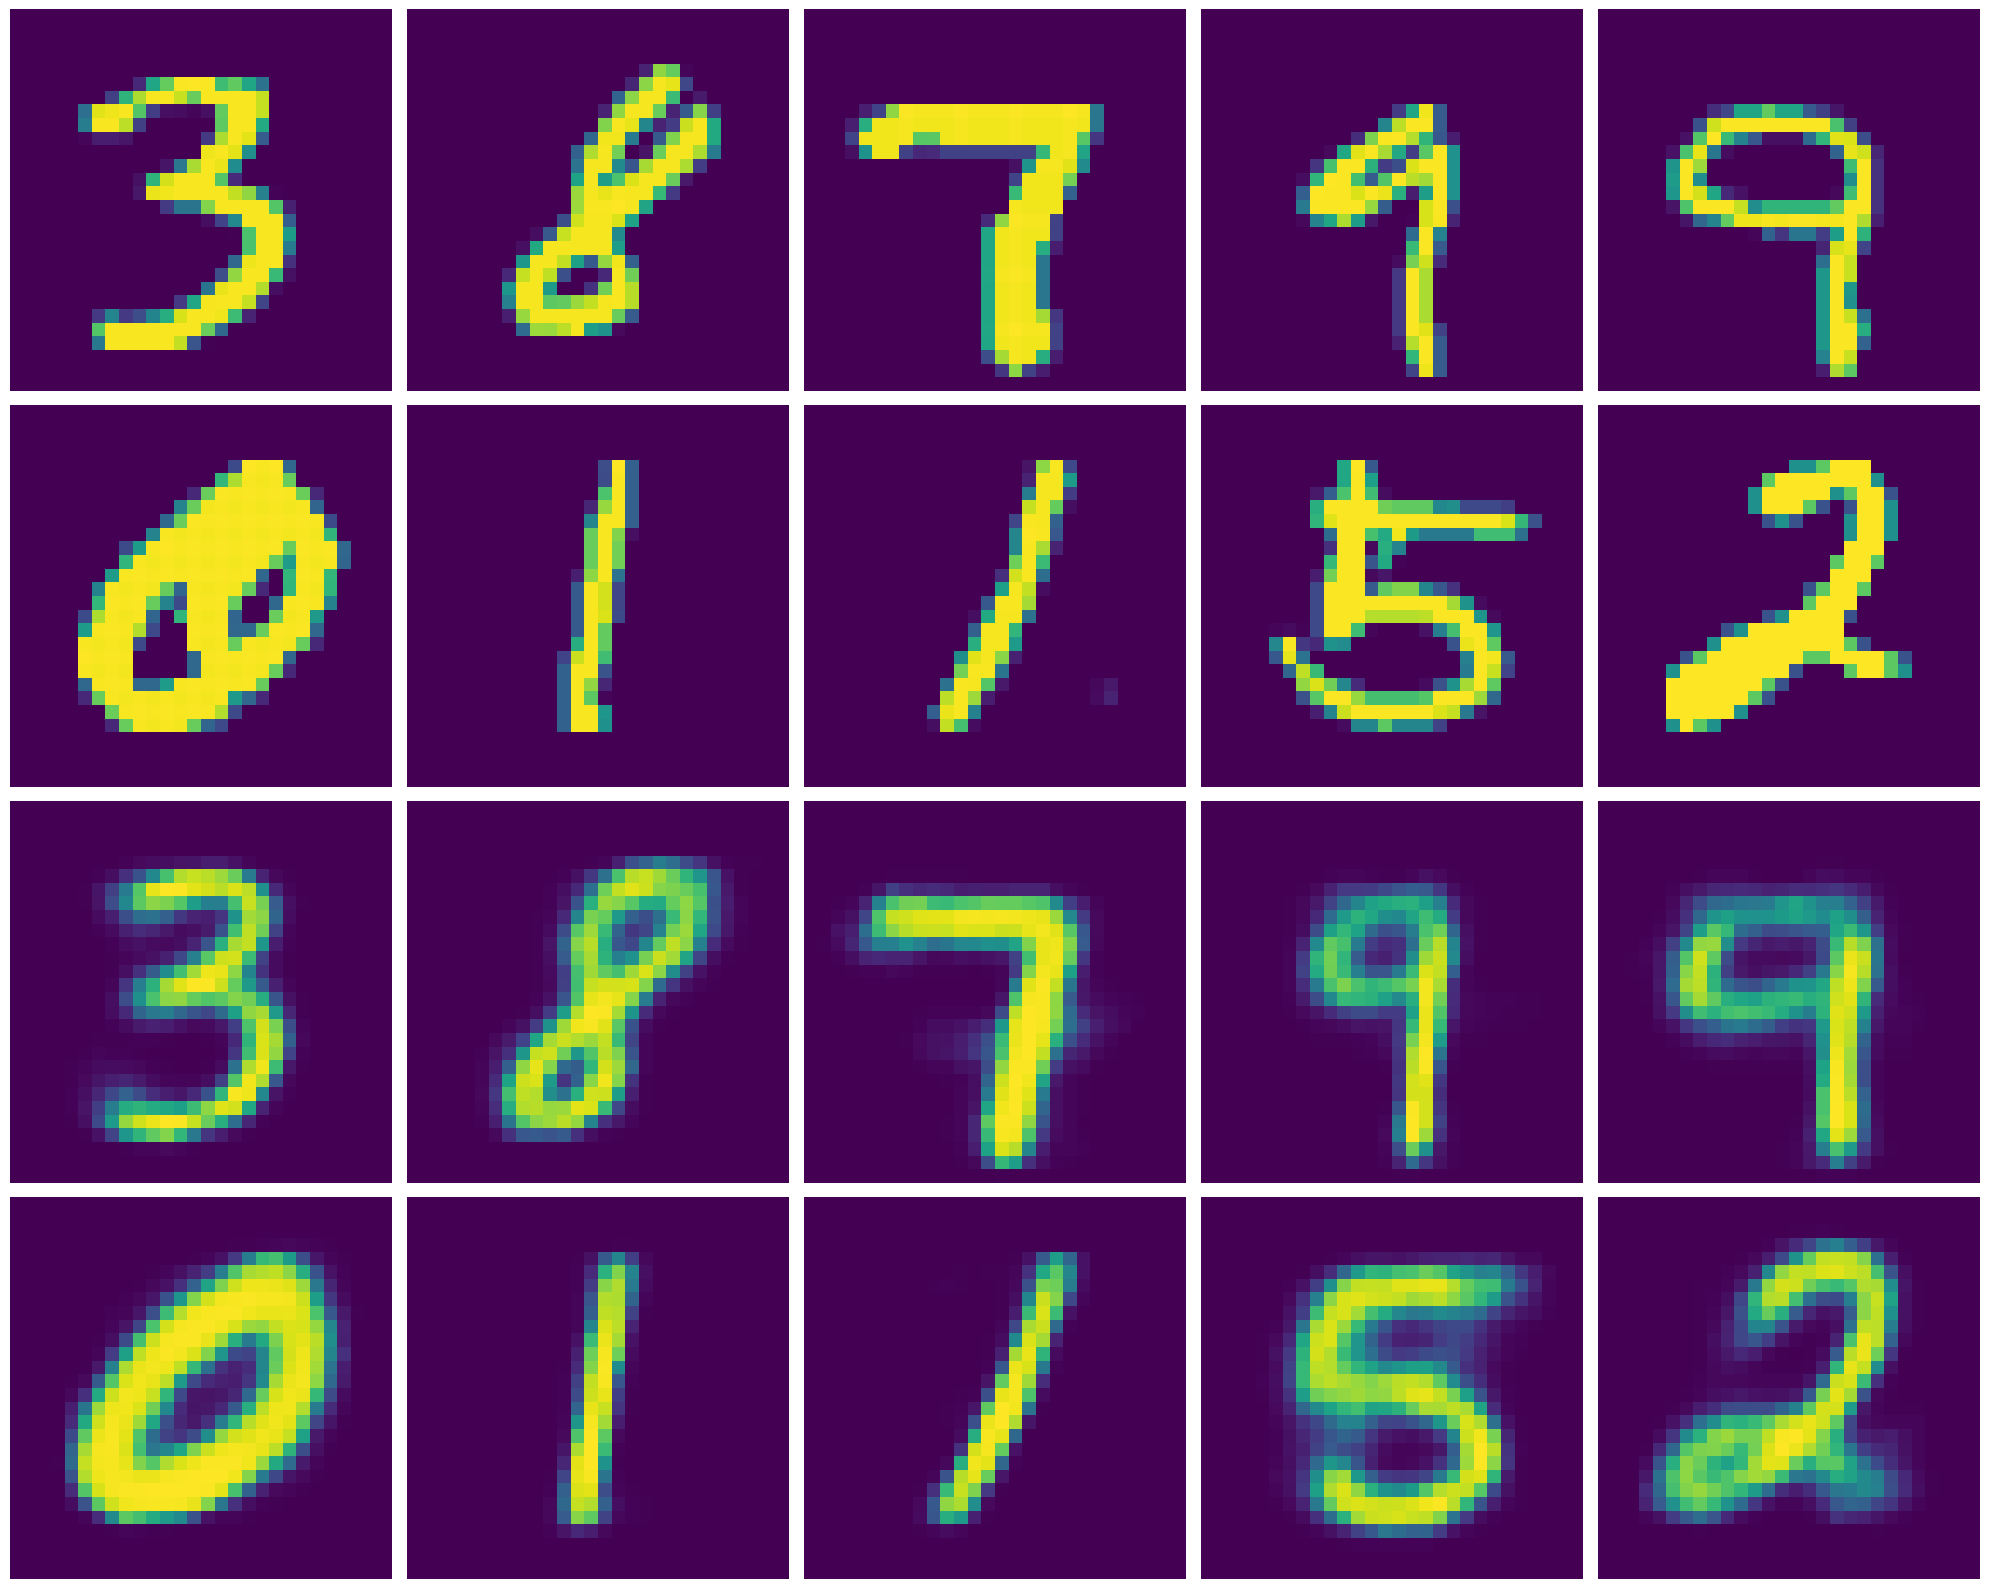

In [44]:
show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


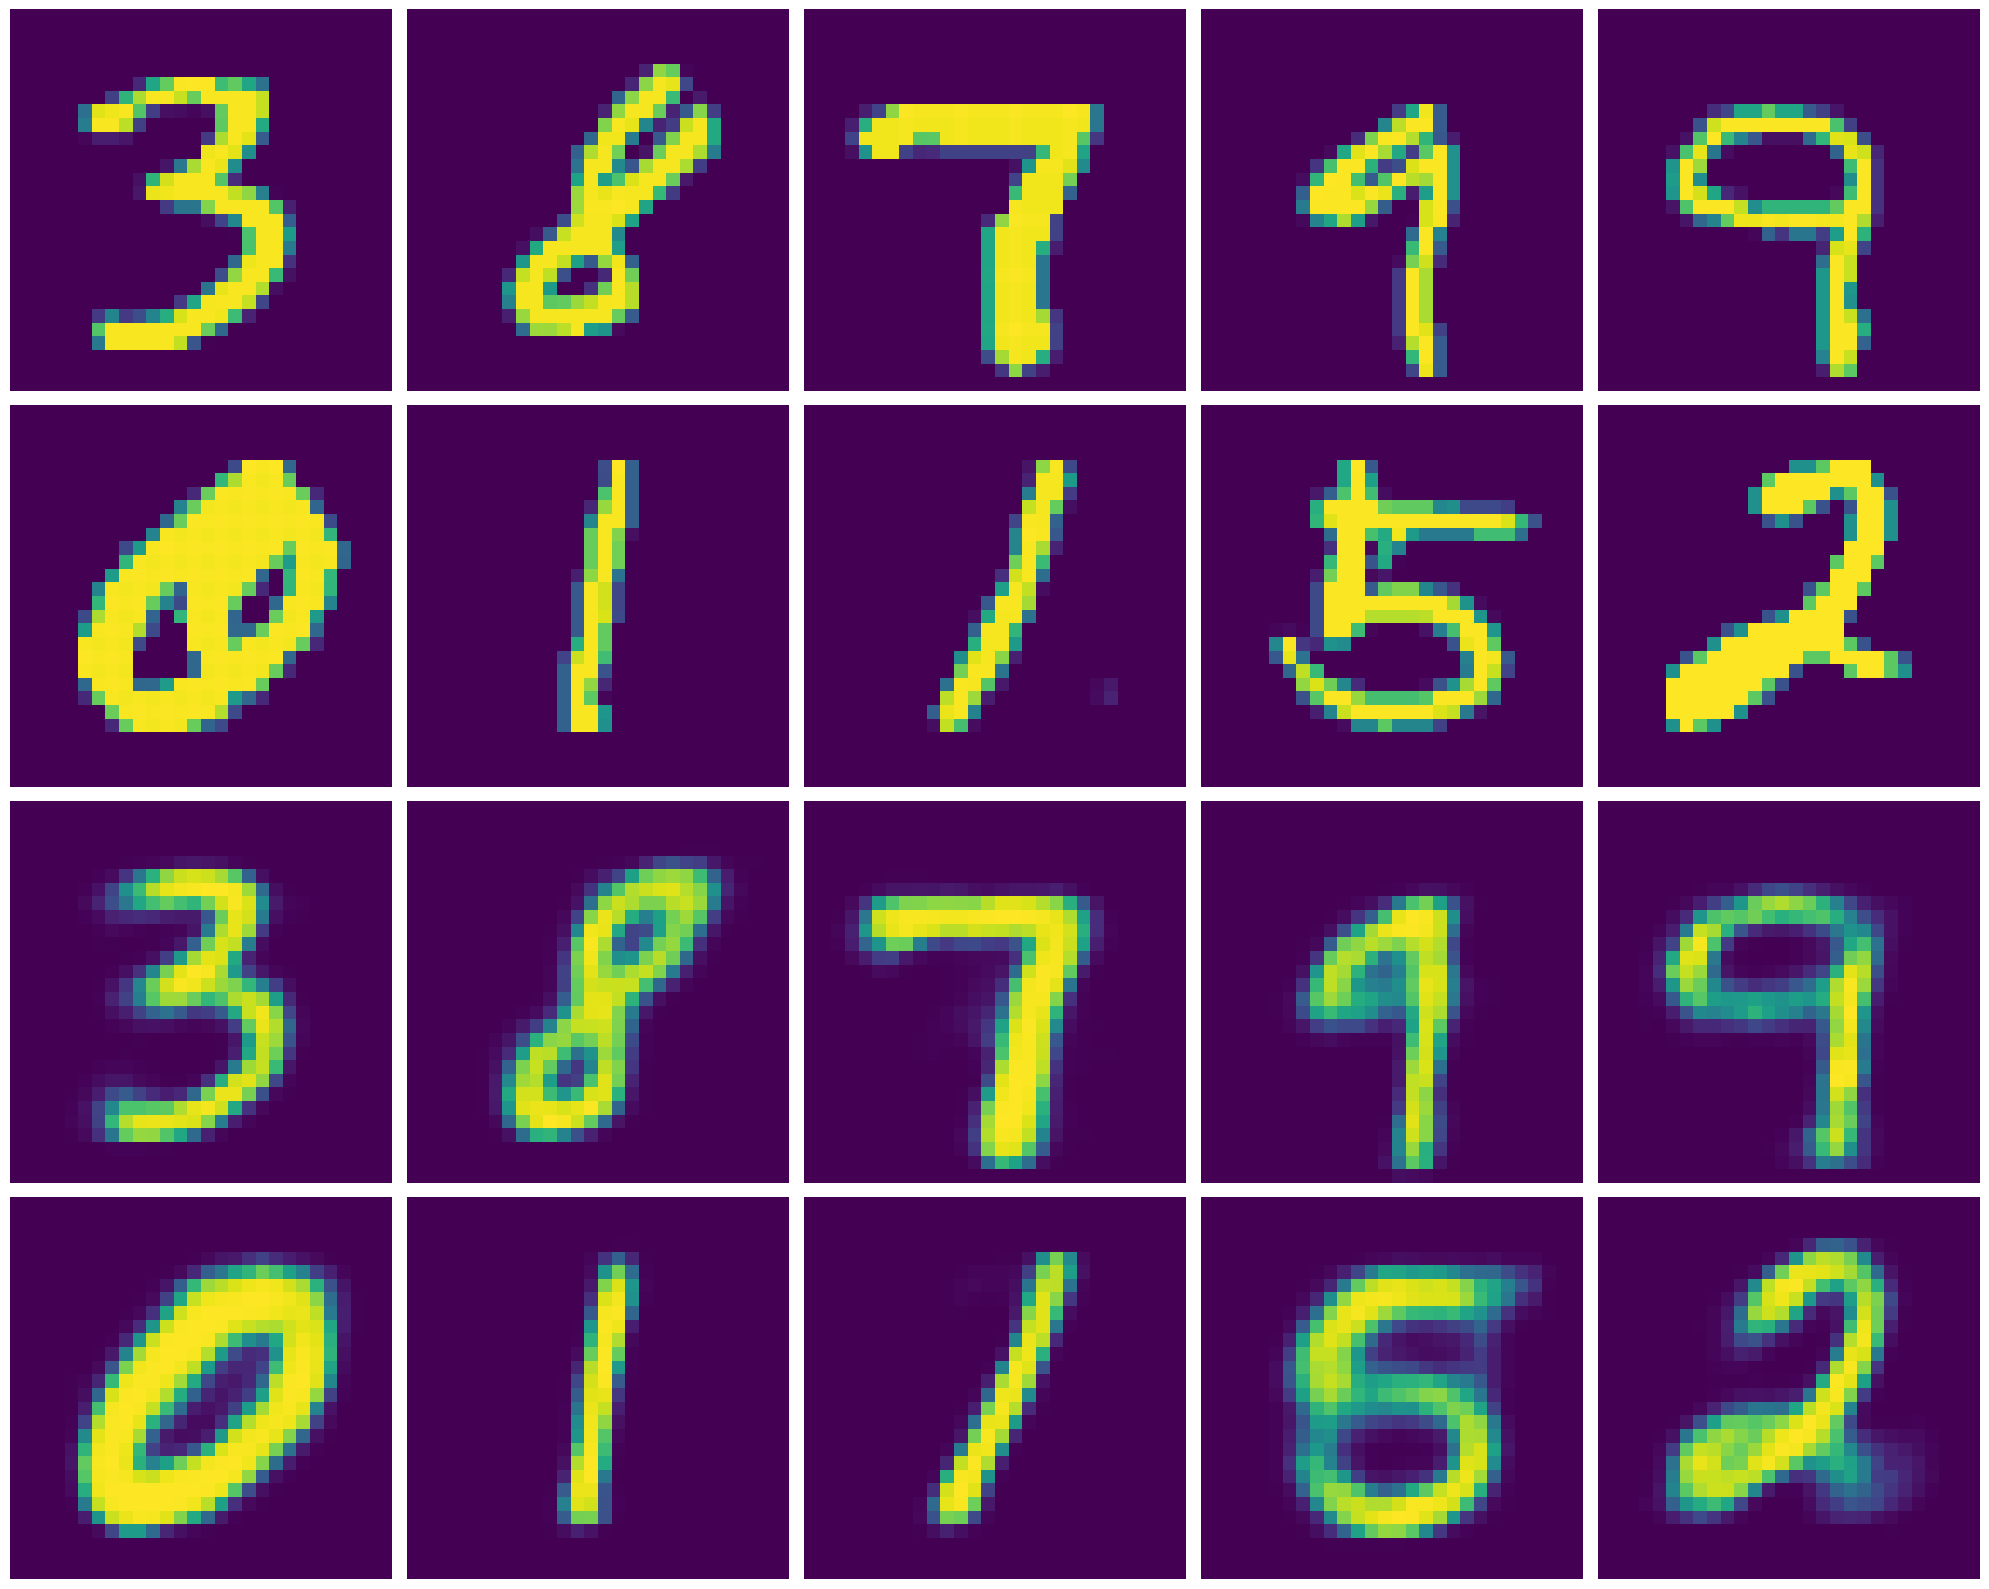

In [46]:
latent_dim = 6

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


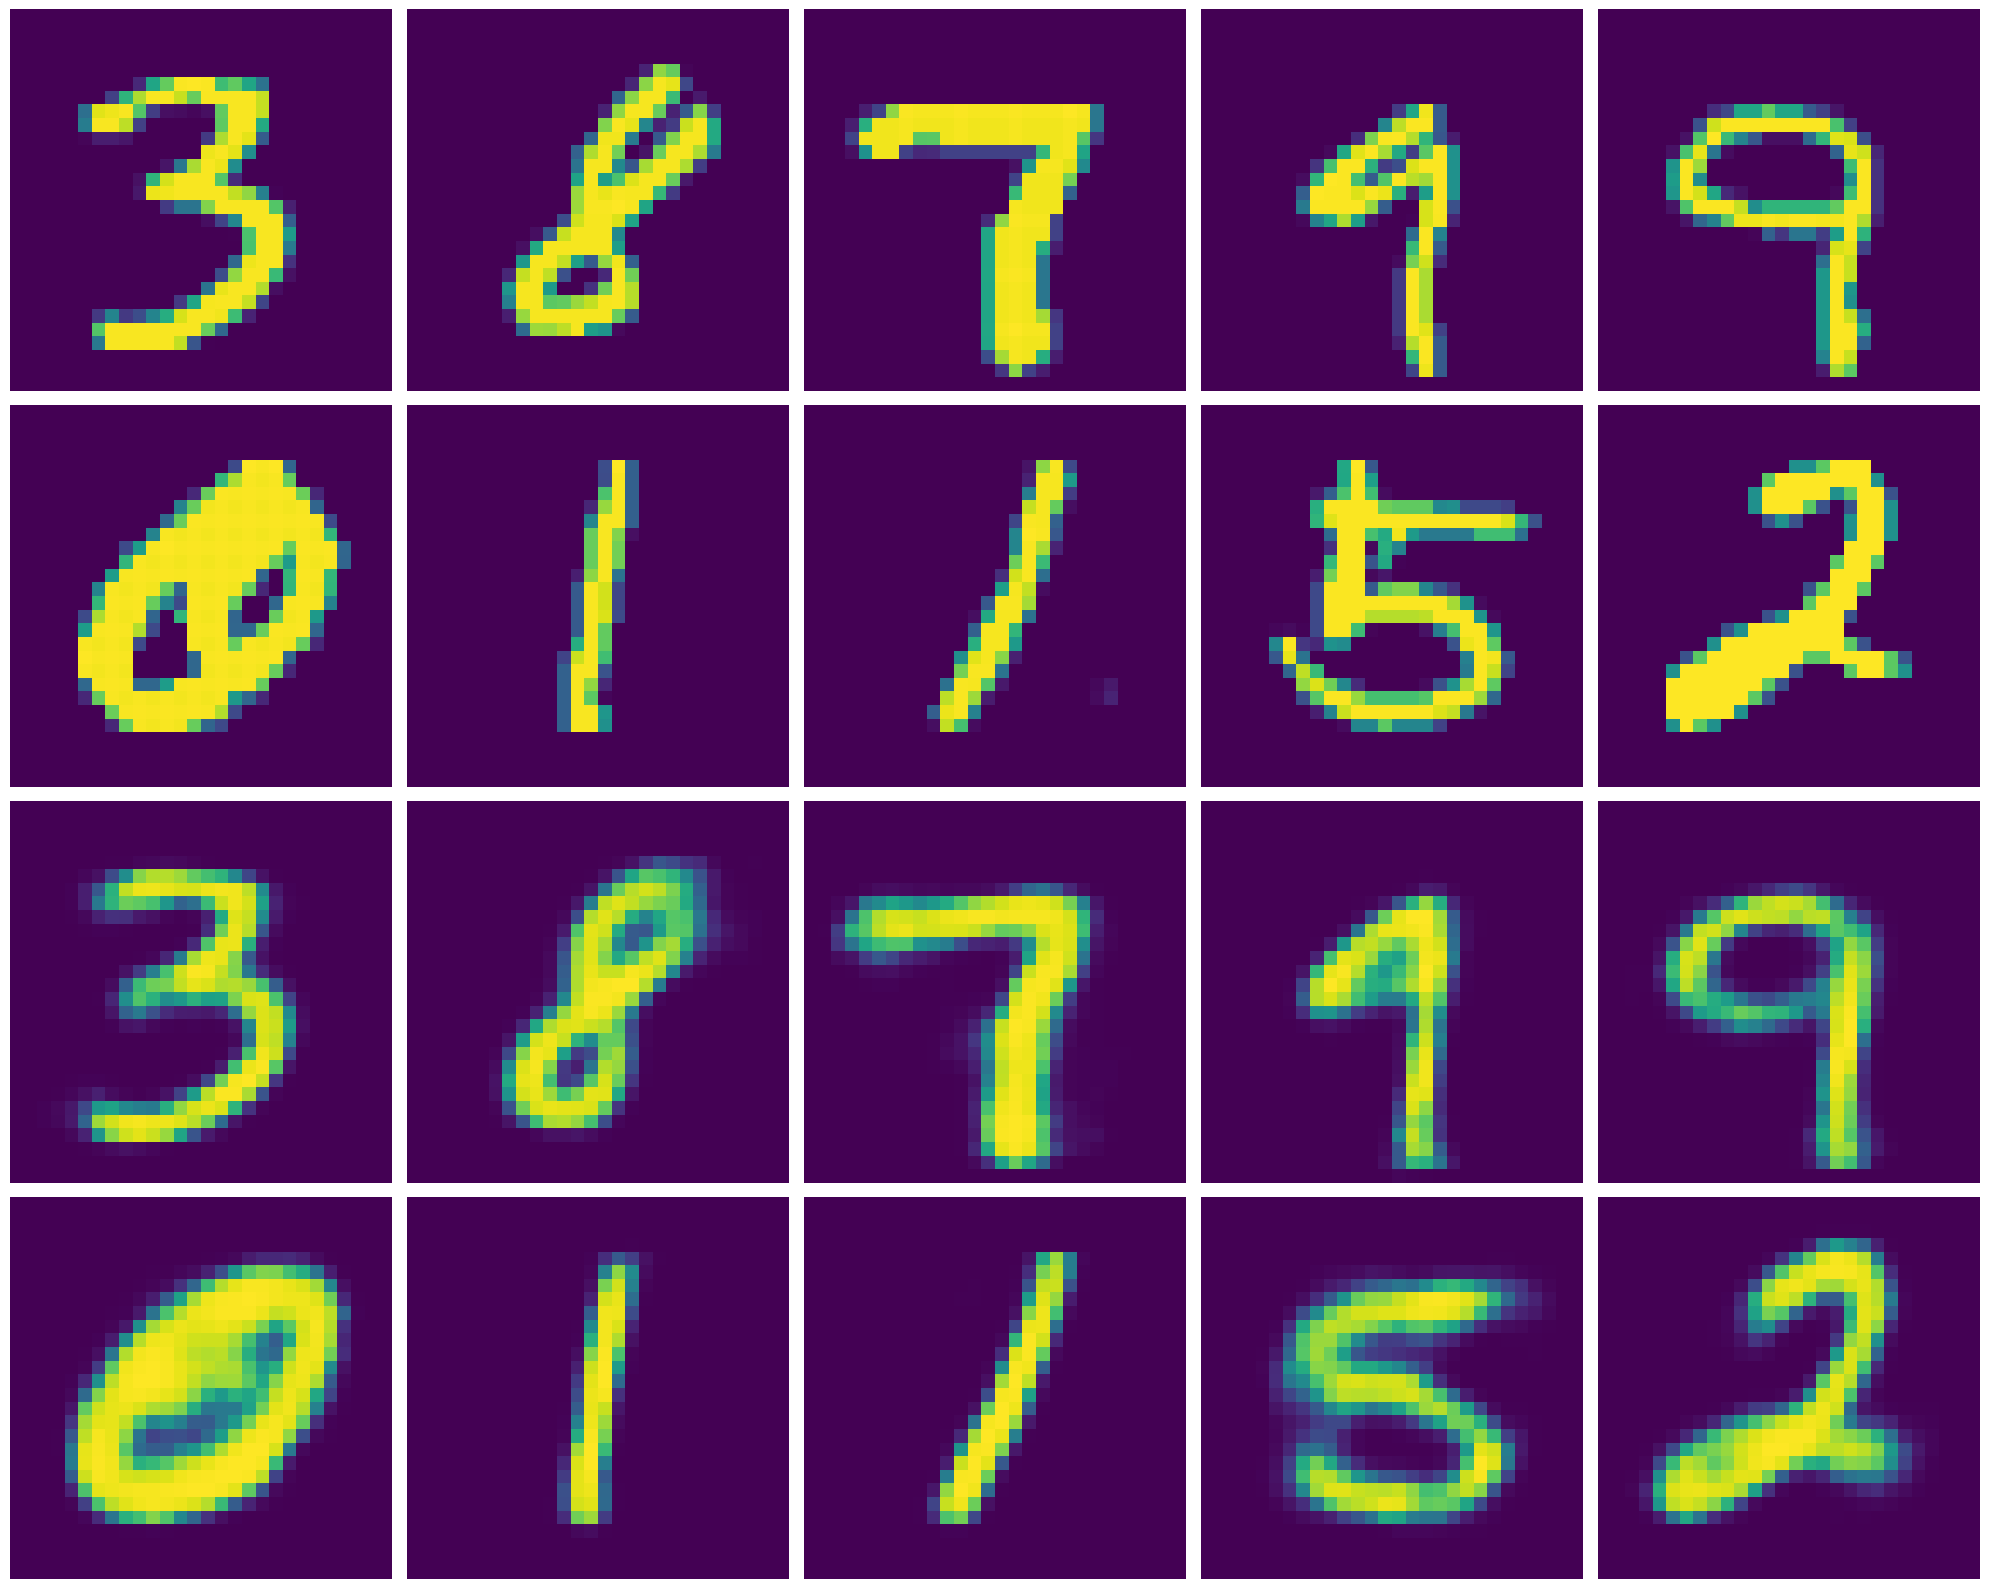

In [47]:
latent_dim = 8

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


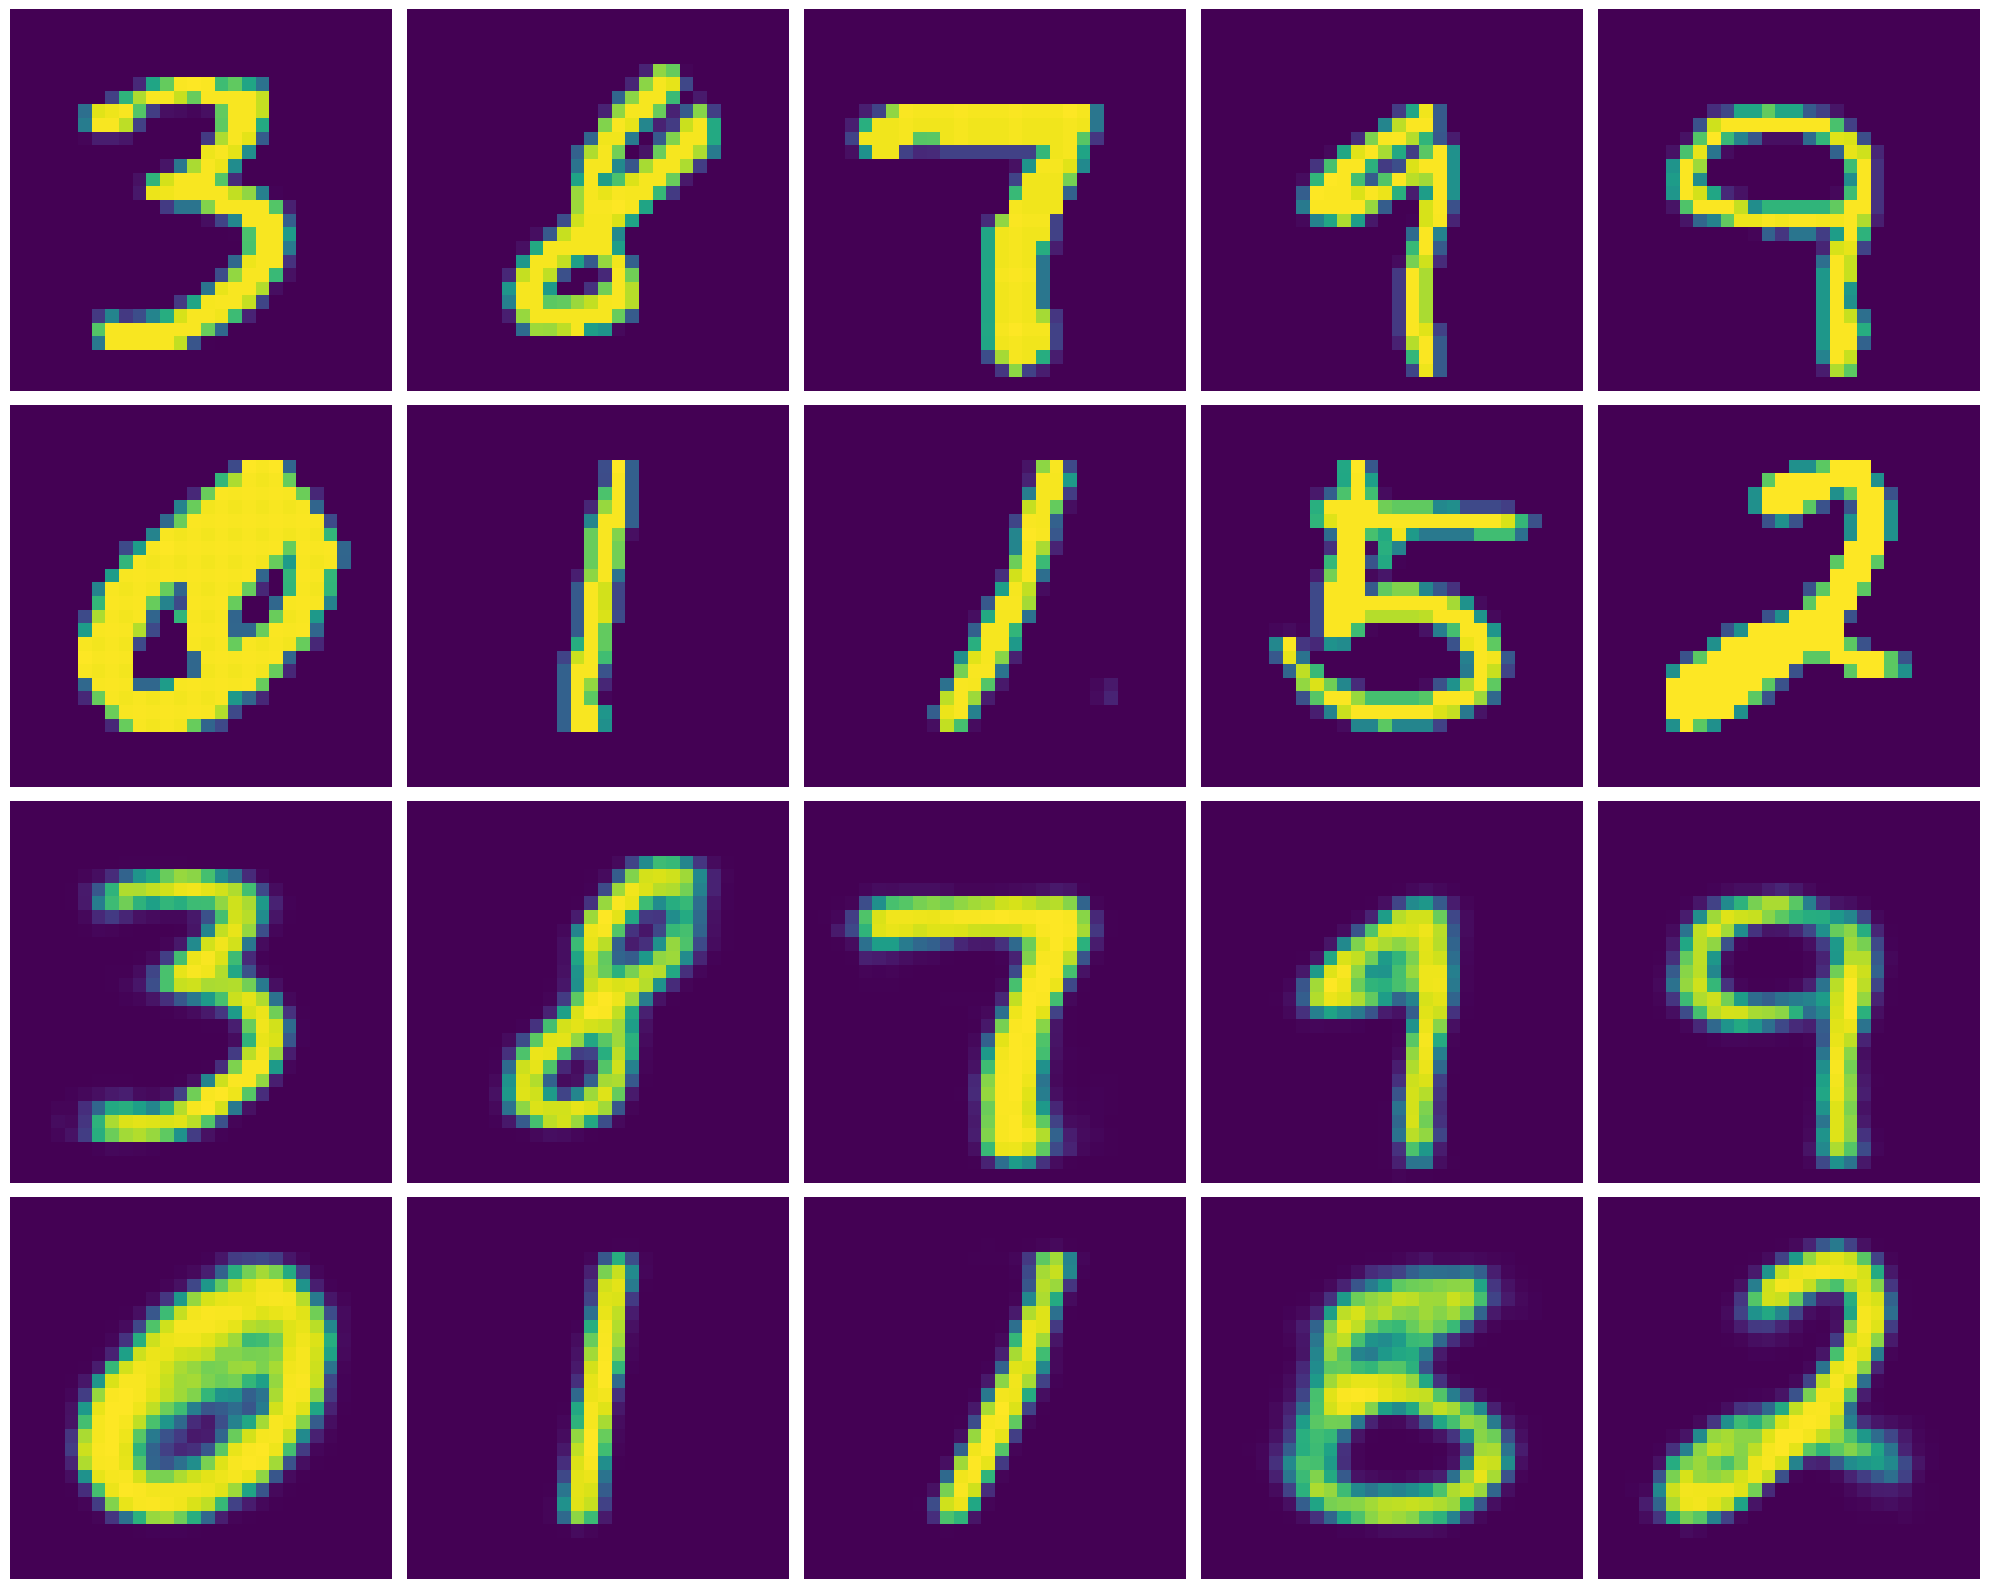

In [48]:
latent_dim = 10

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.80s/it]


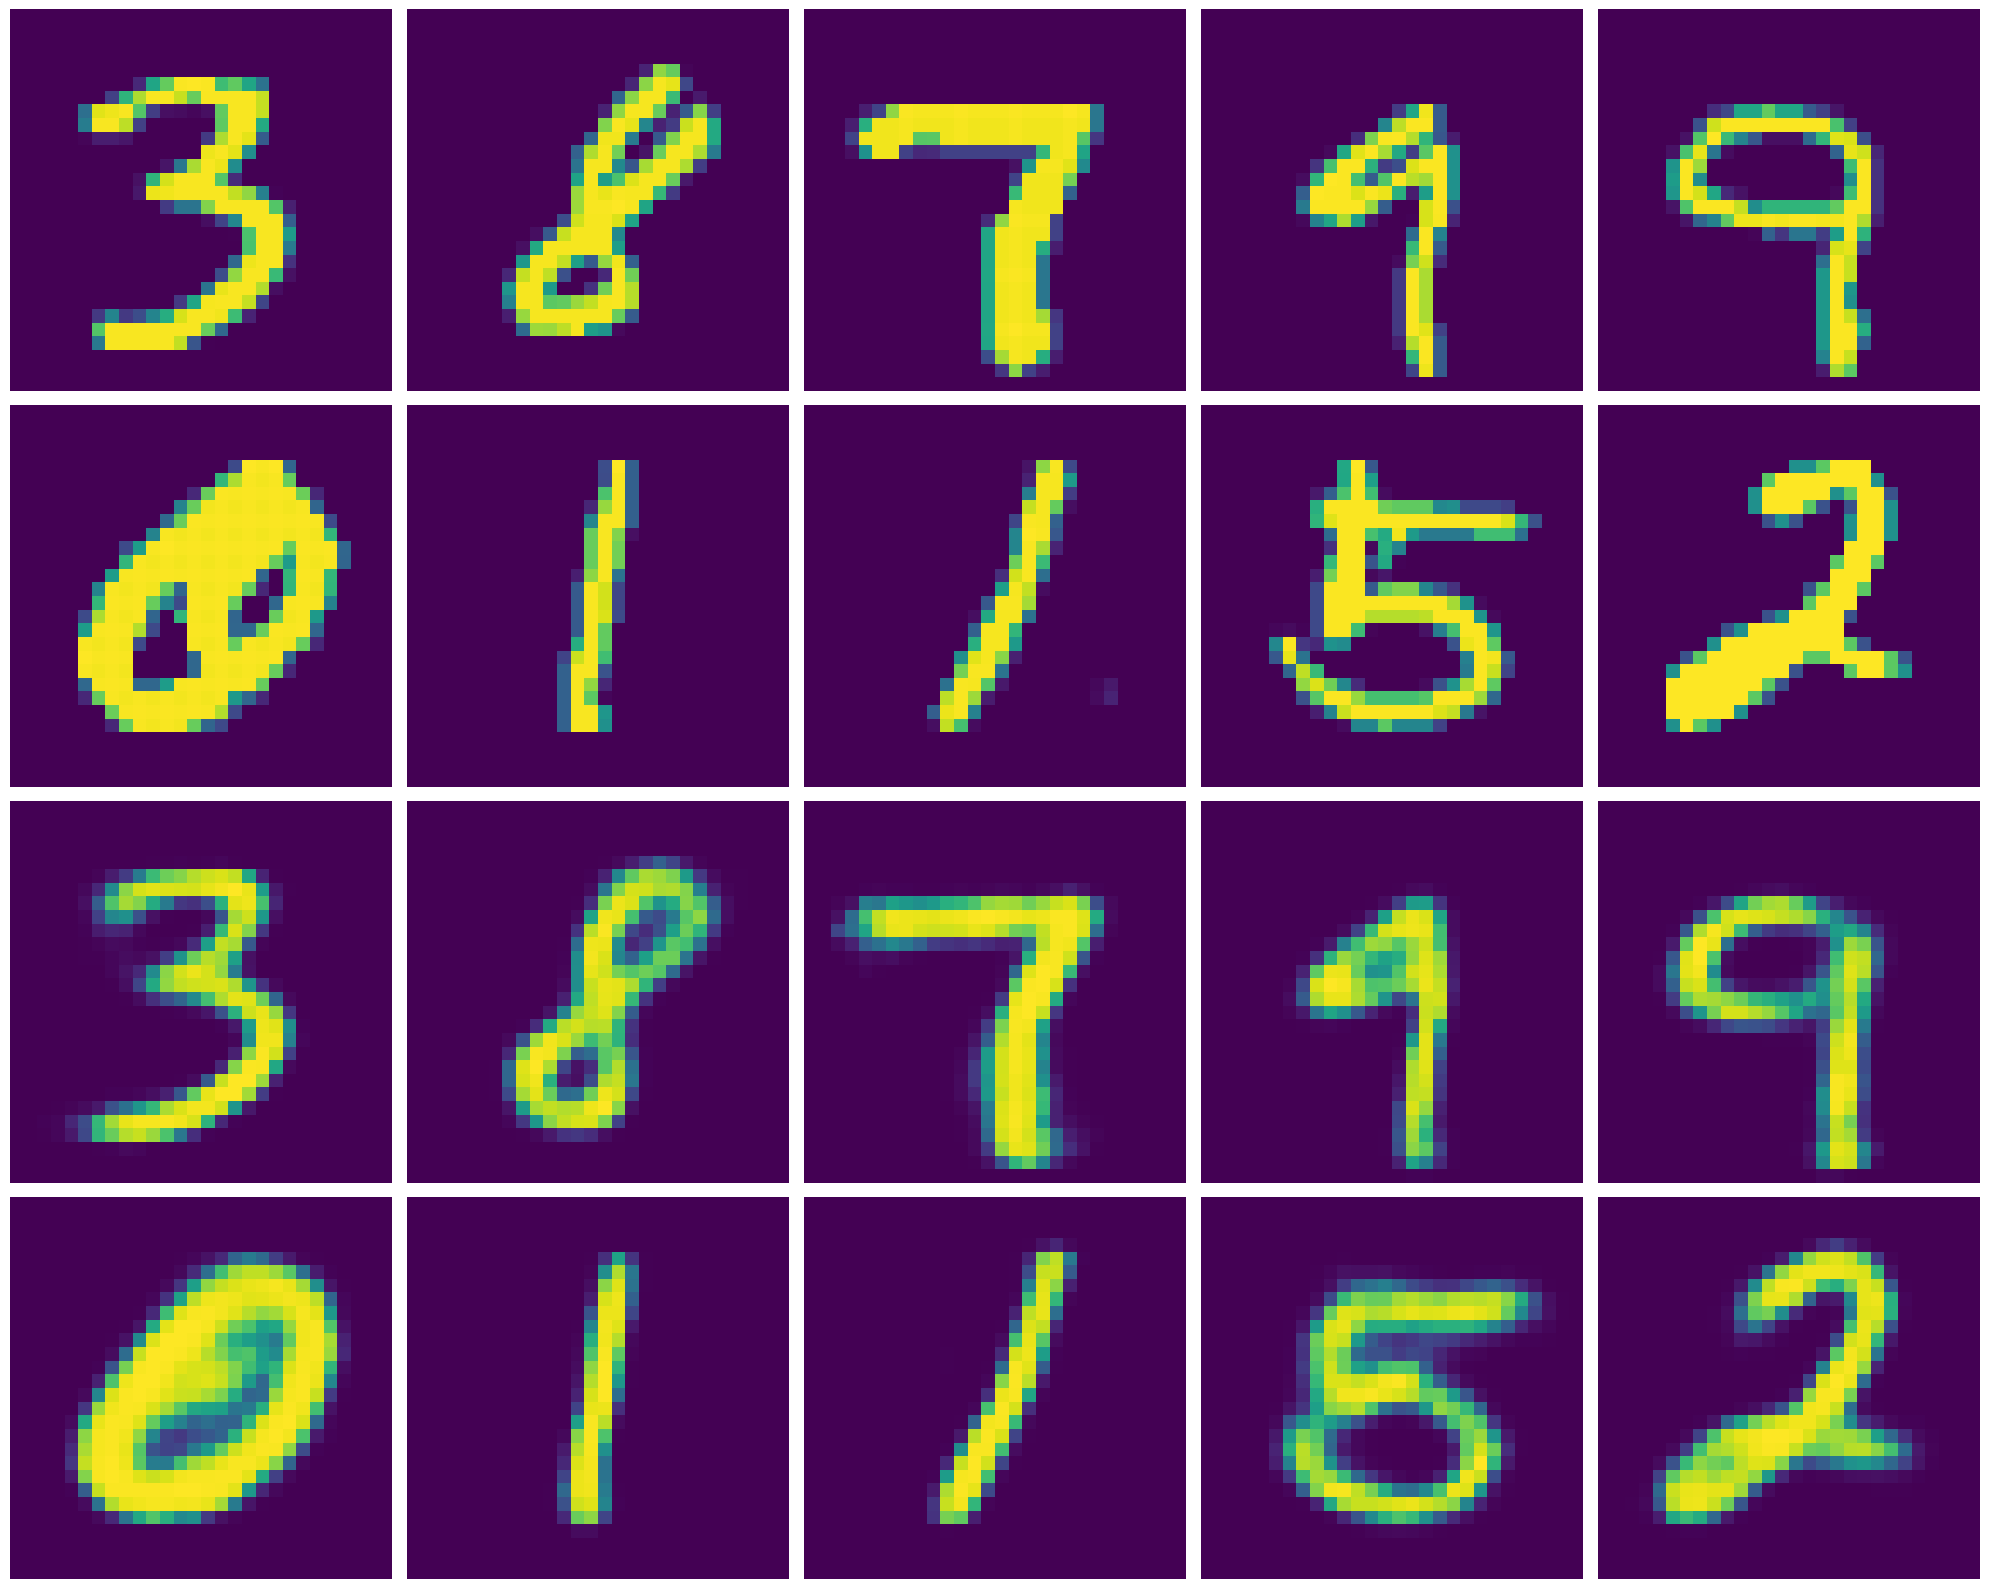

In [49]:
latent_dim = 12

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


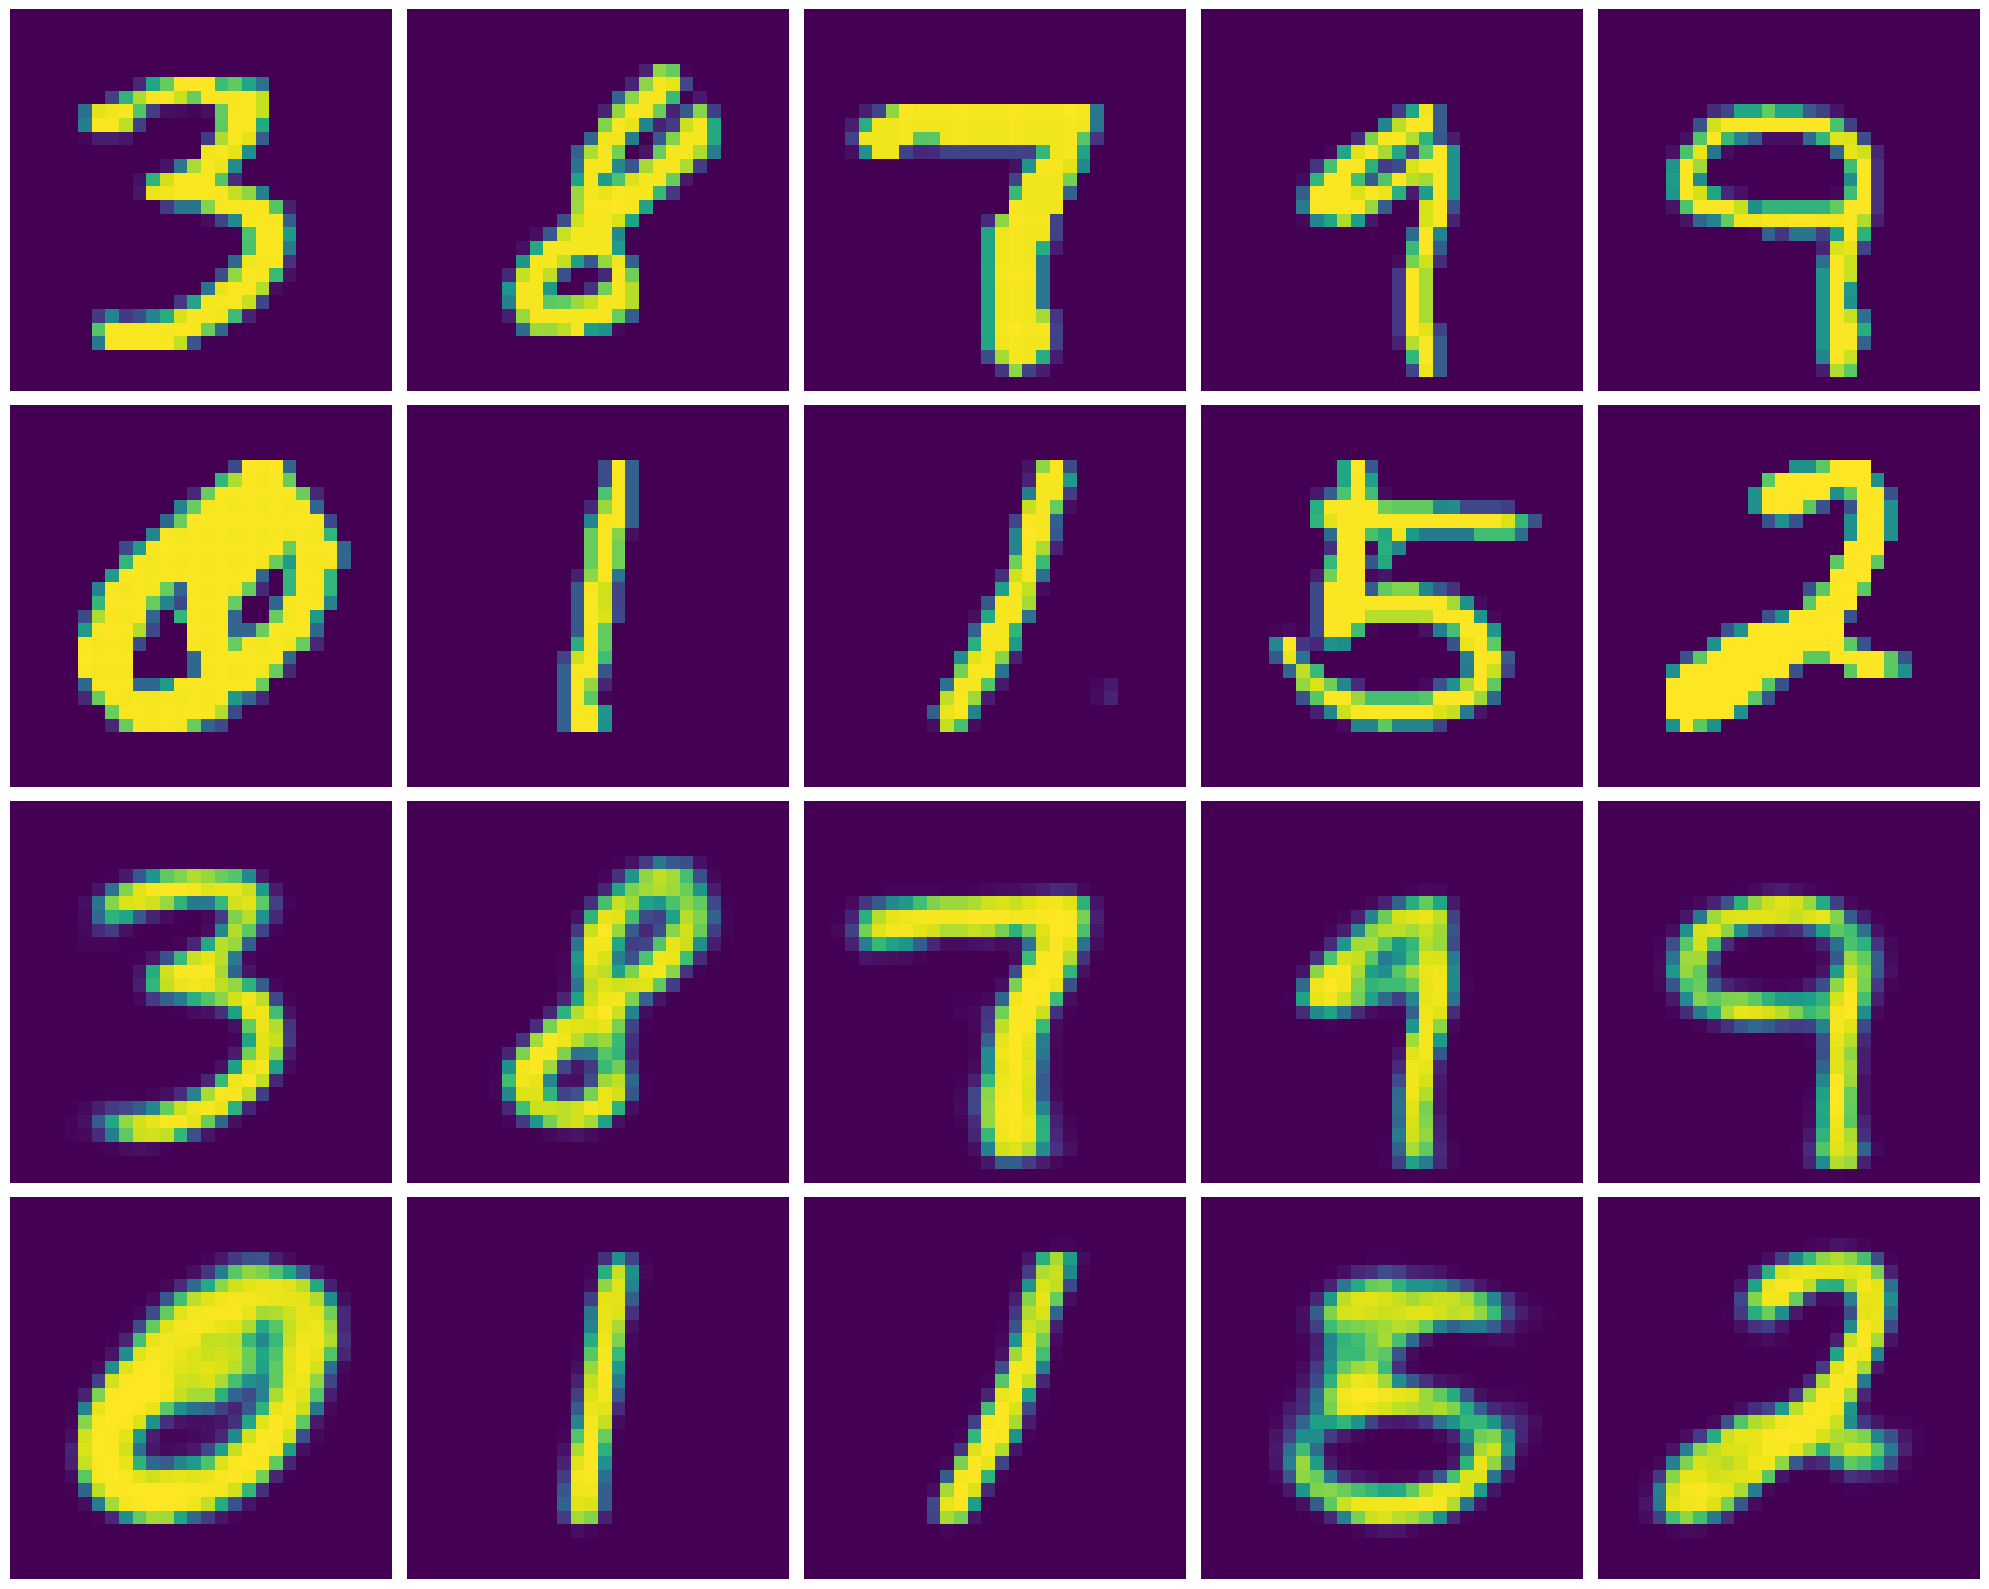

In [50]:
latent_dim = 14

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


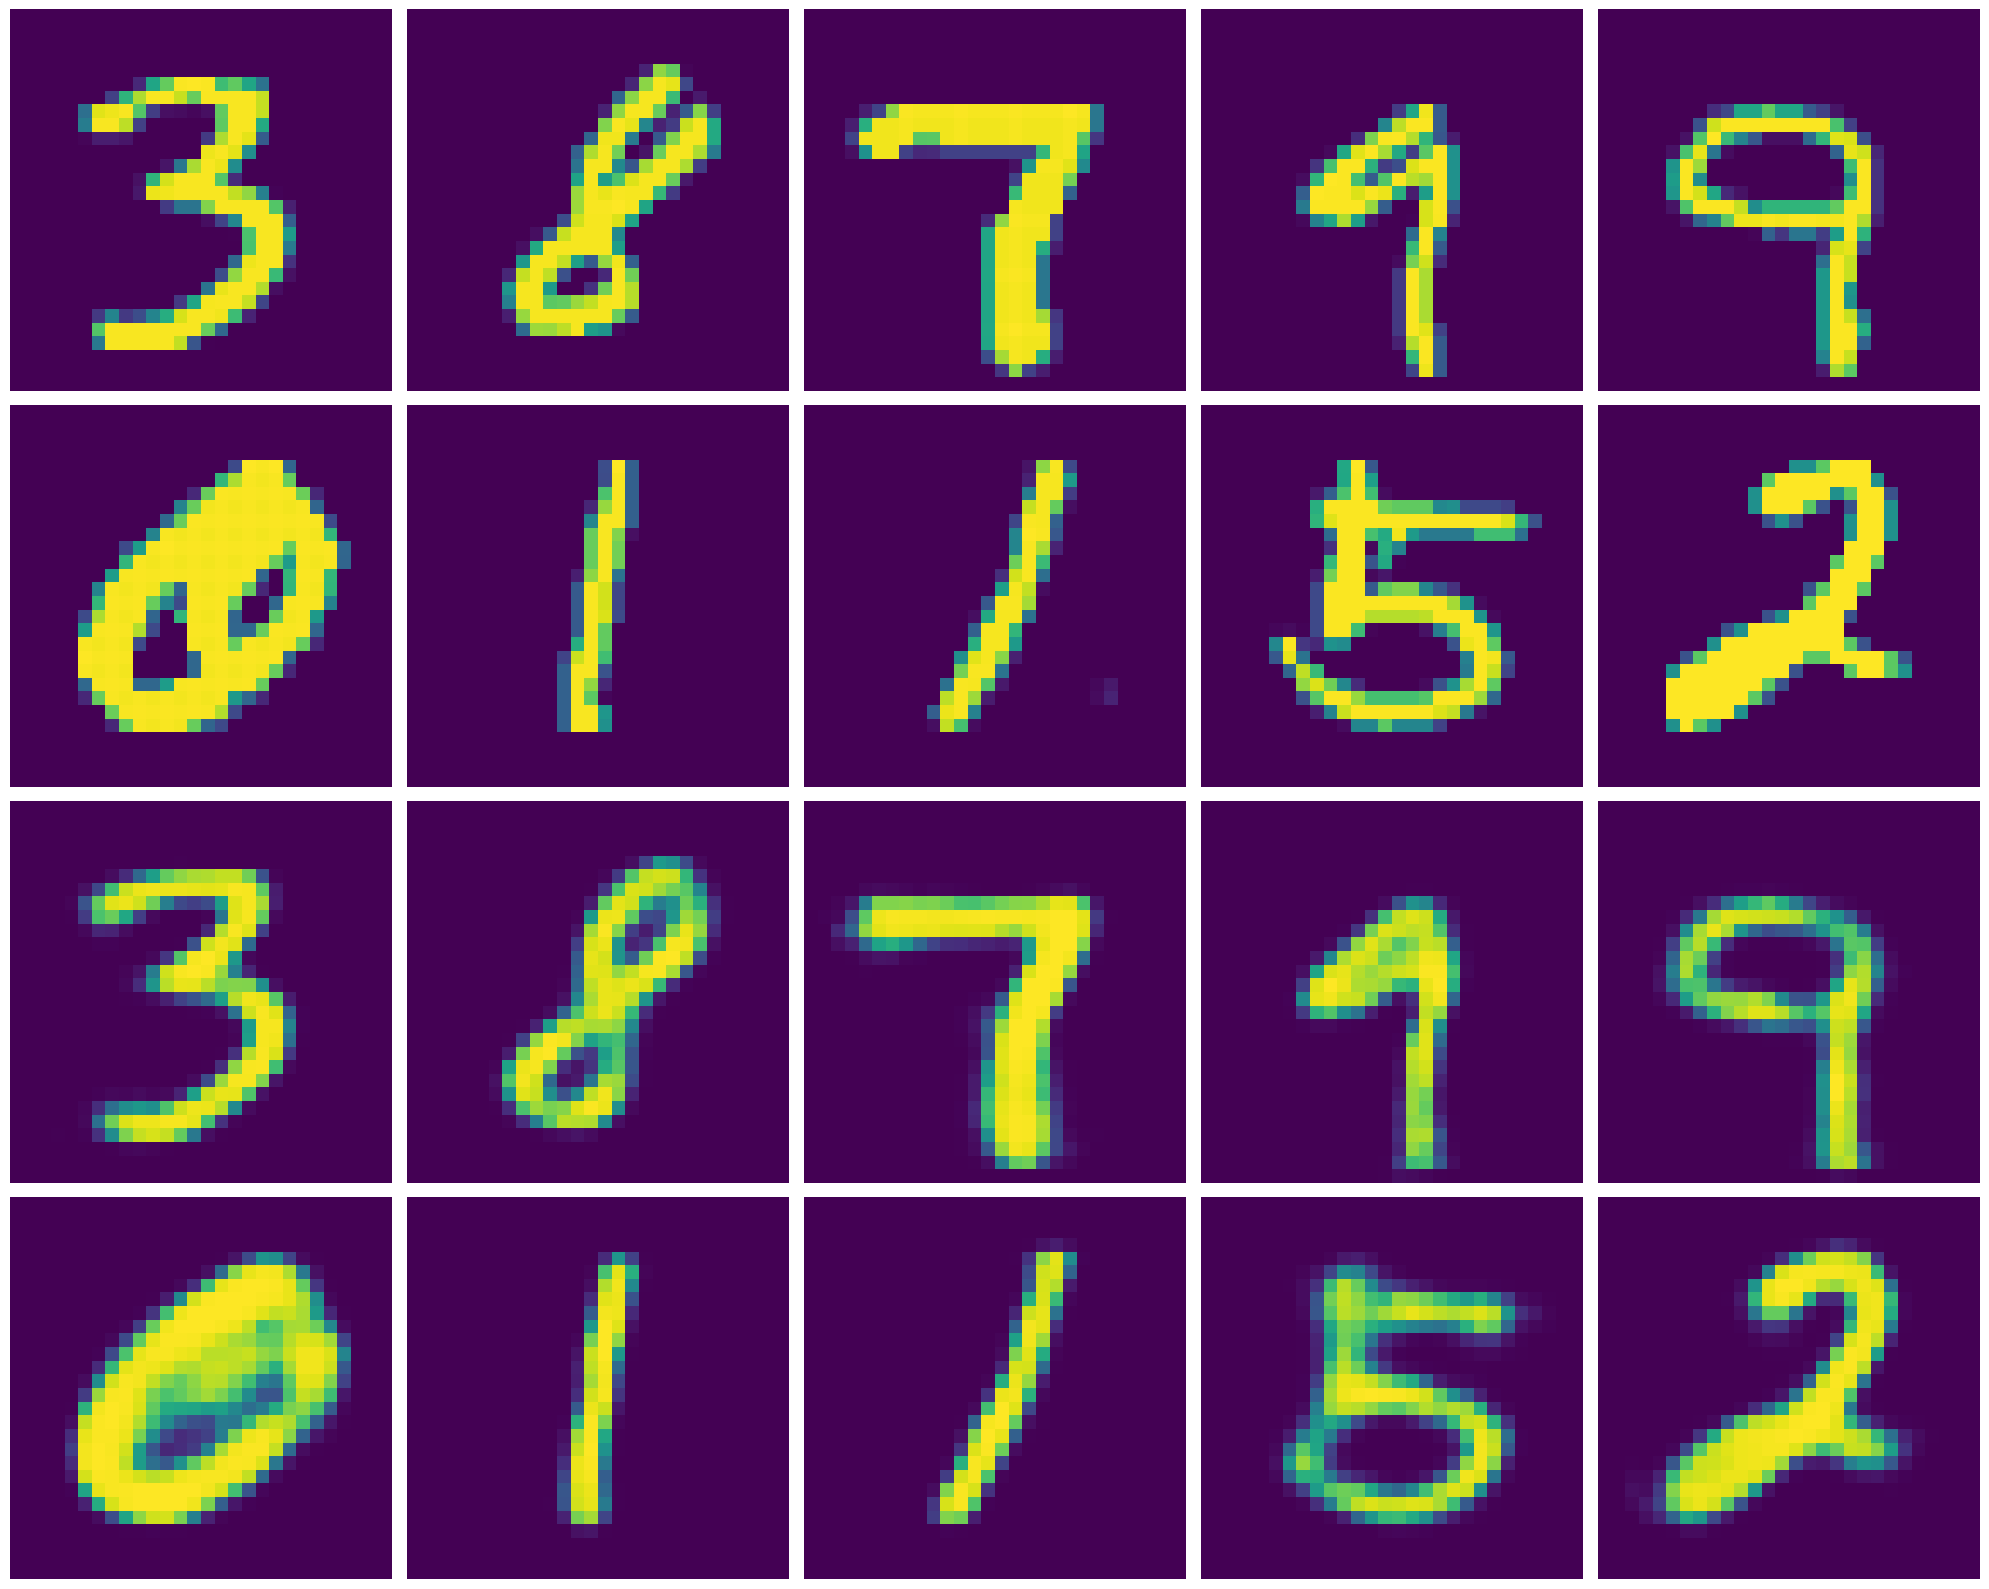

In [51]:
latent_dim = 16

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


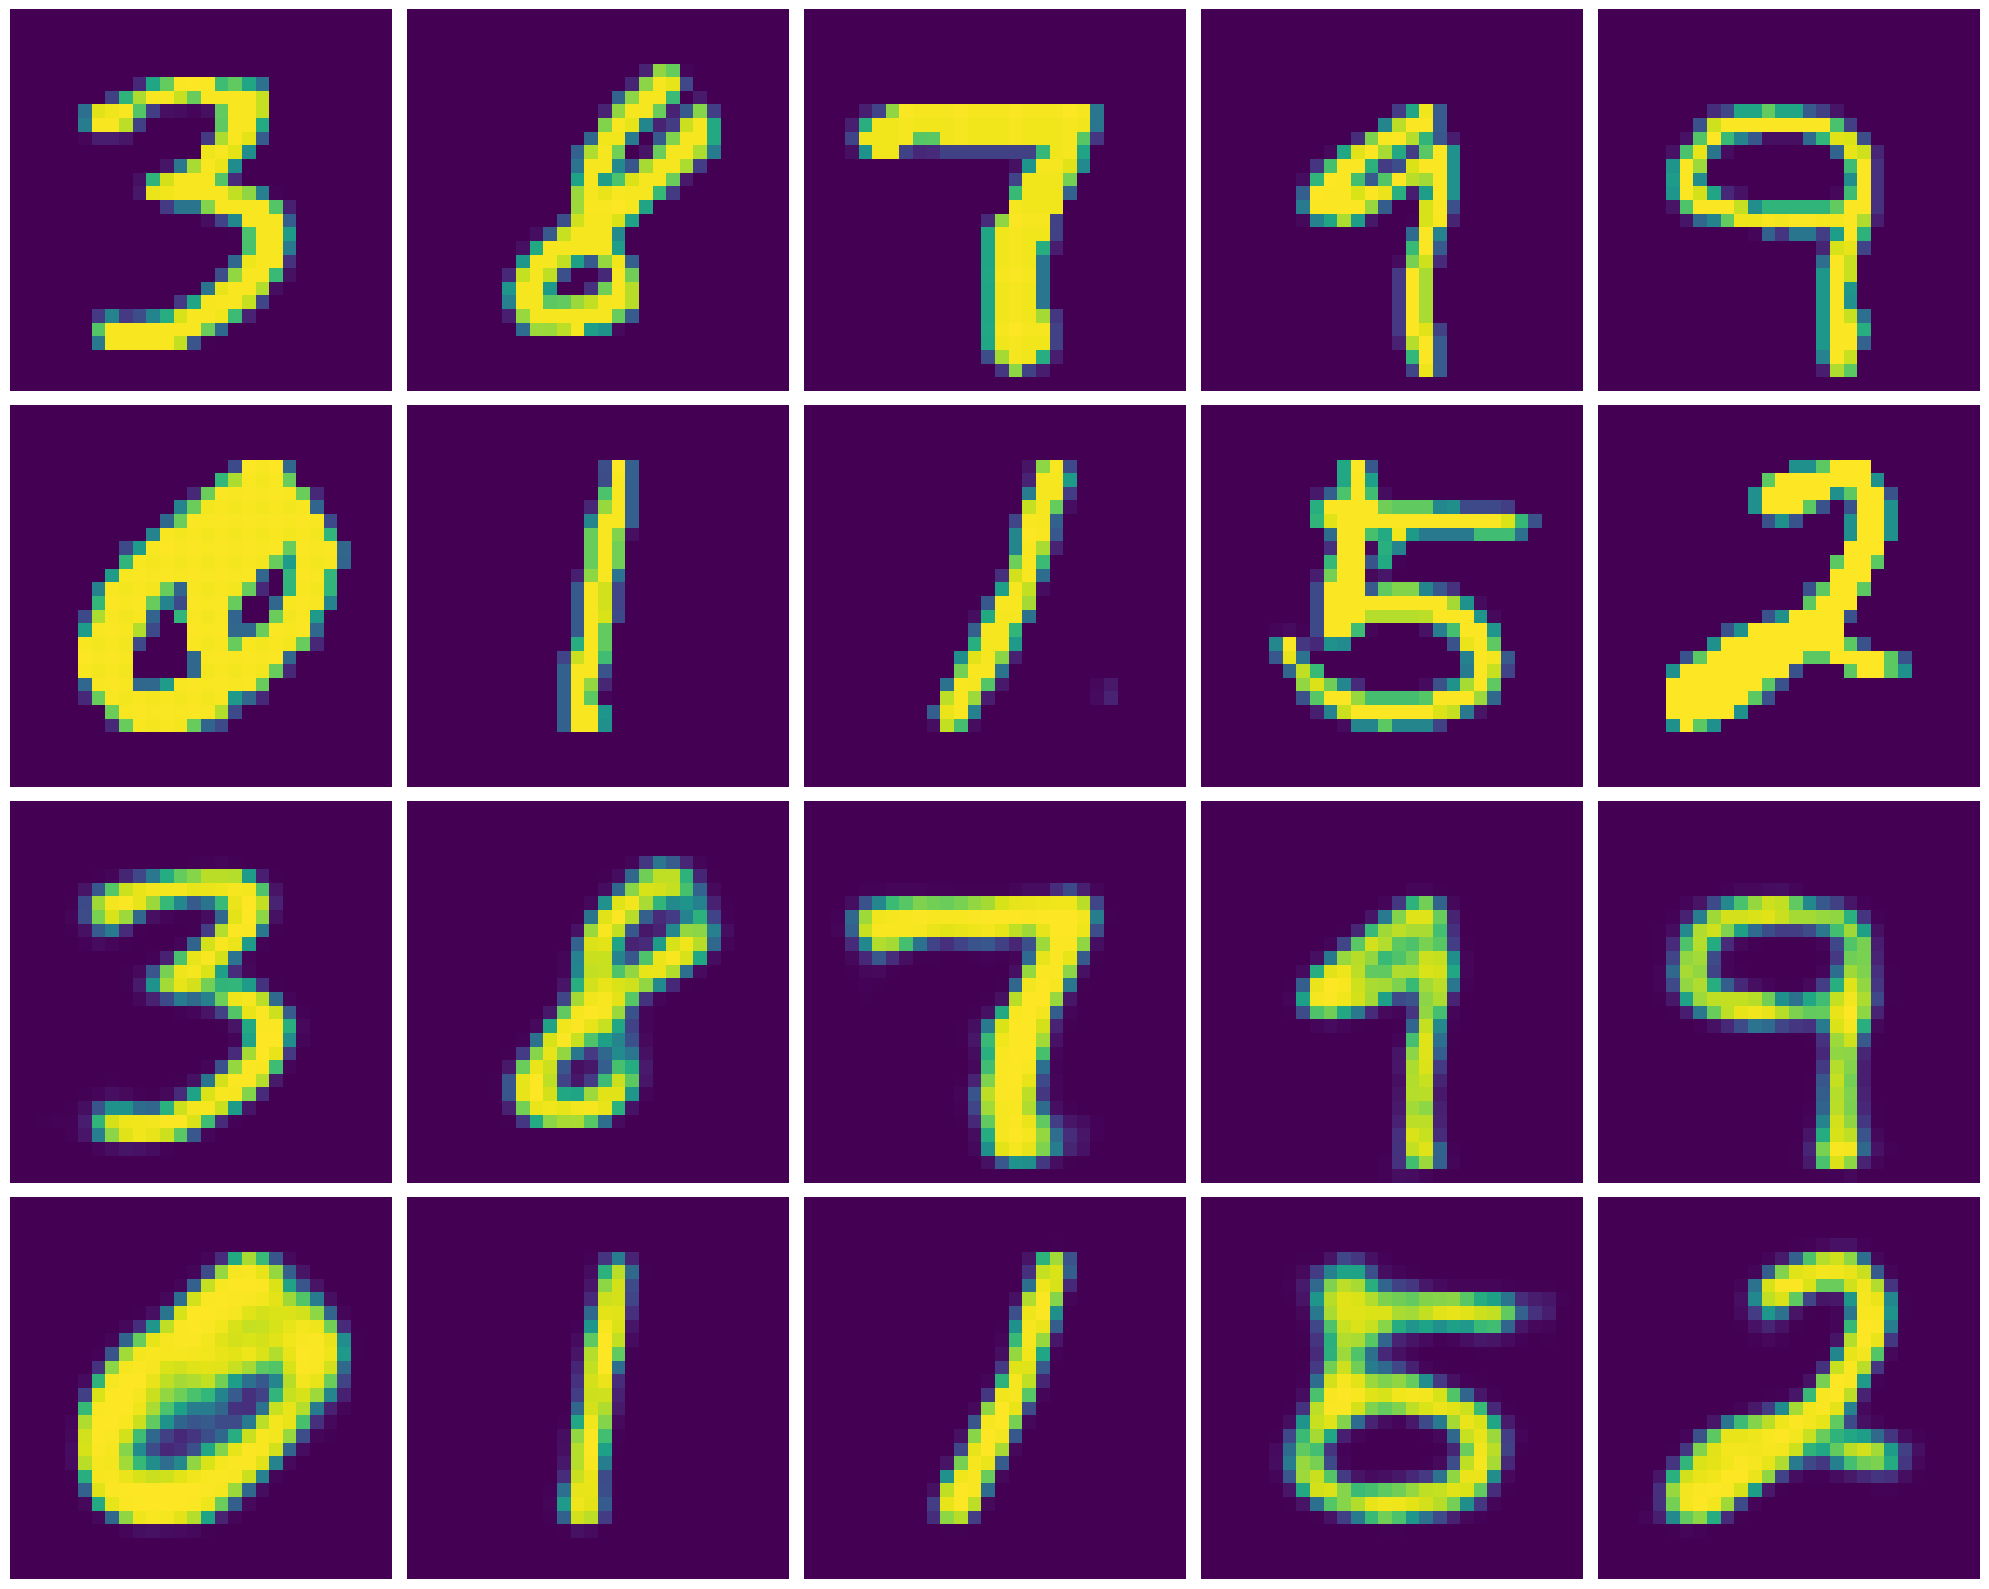

In [52]:
latent_dim = 18

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


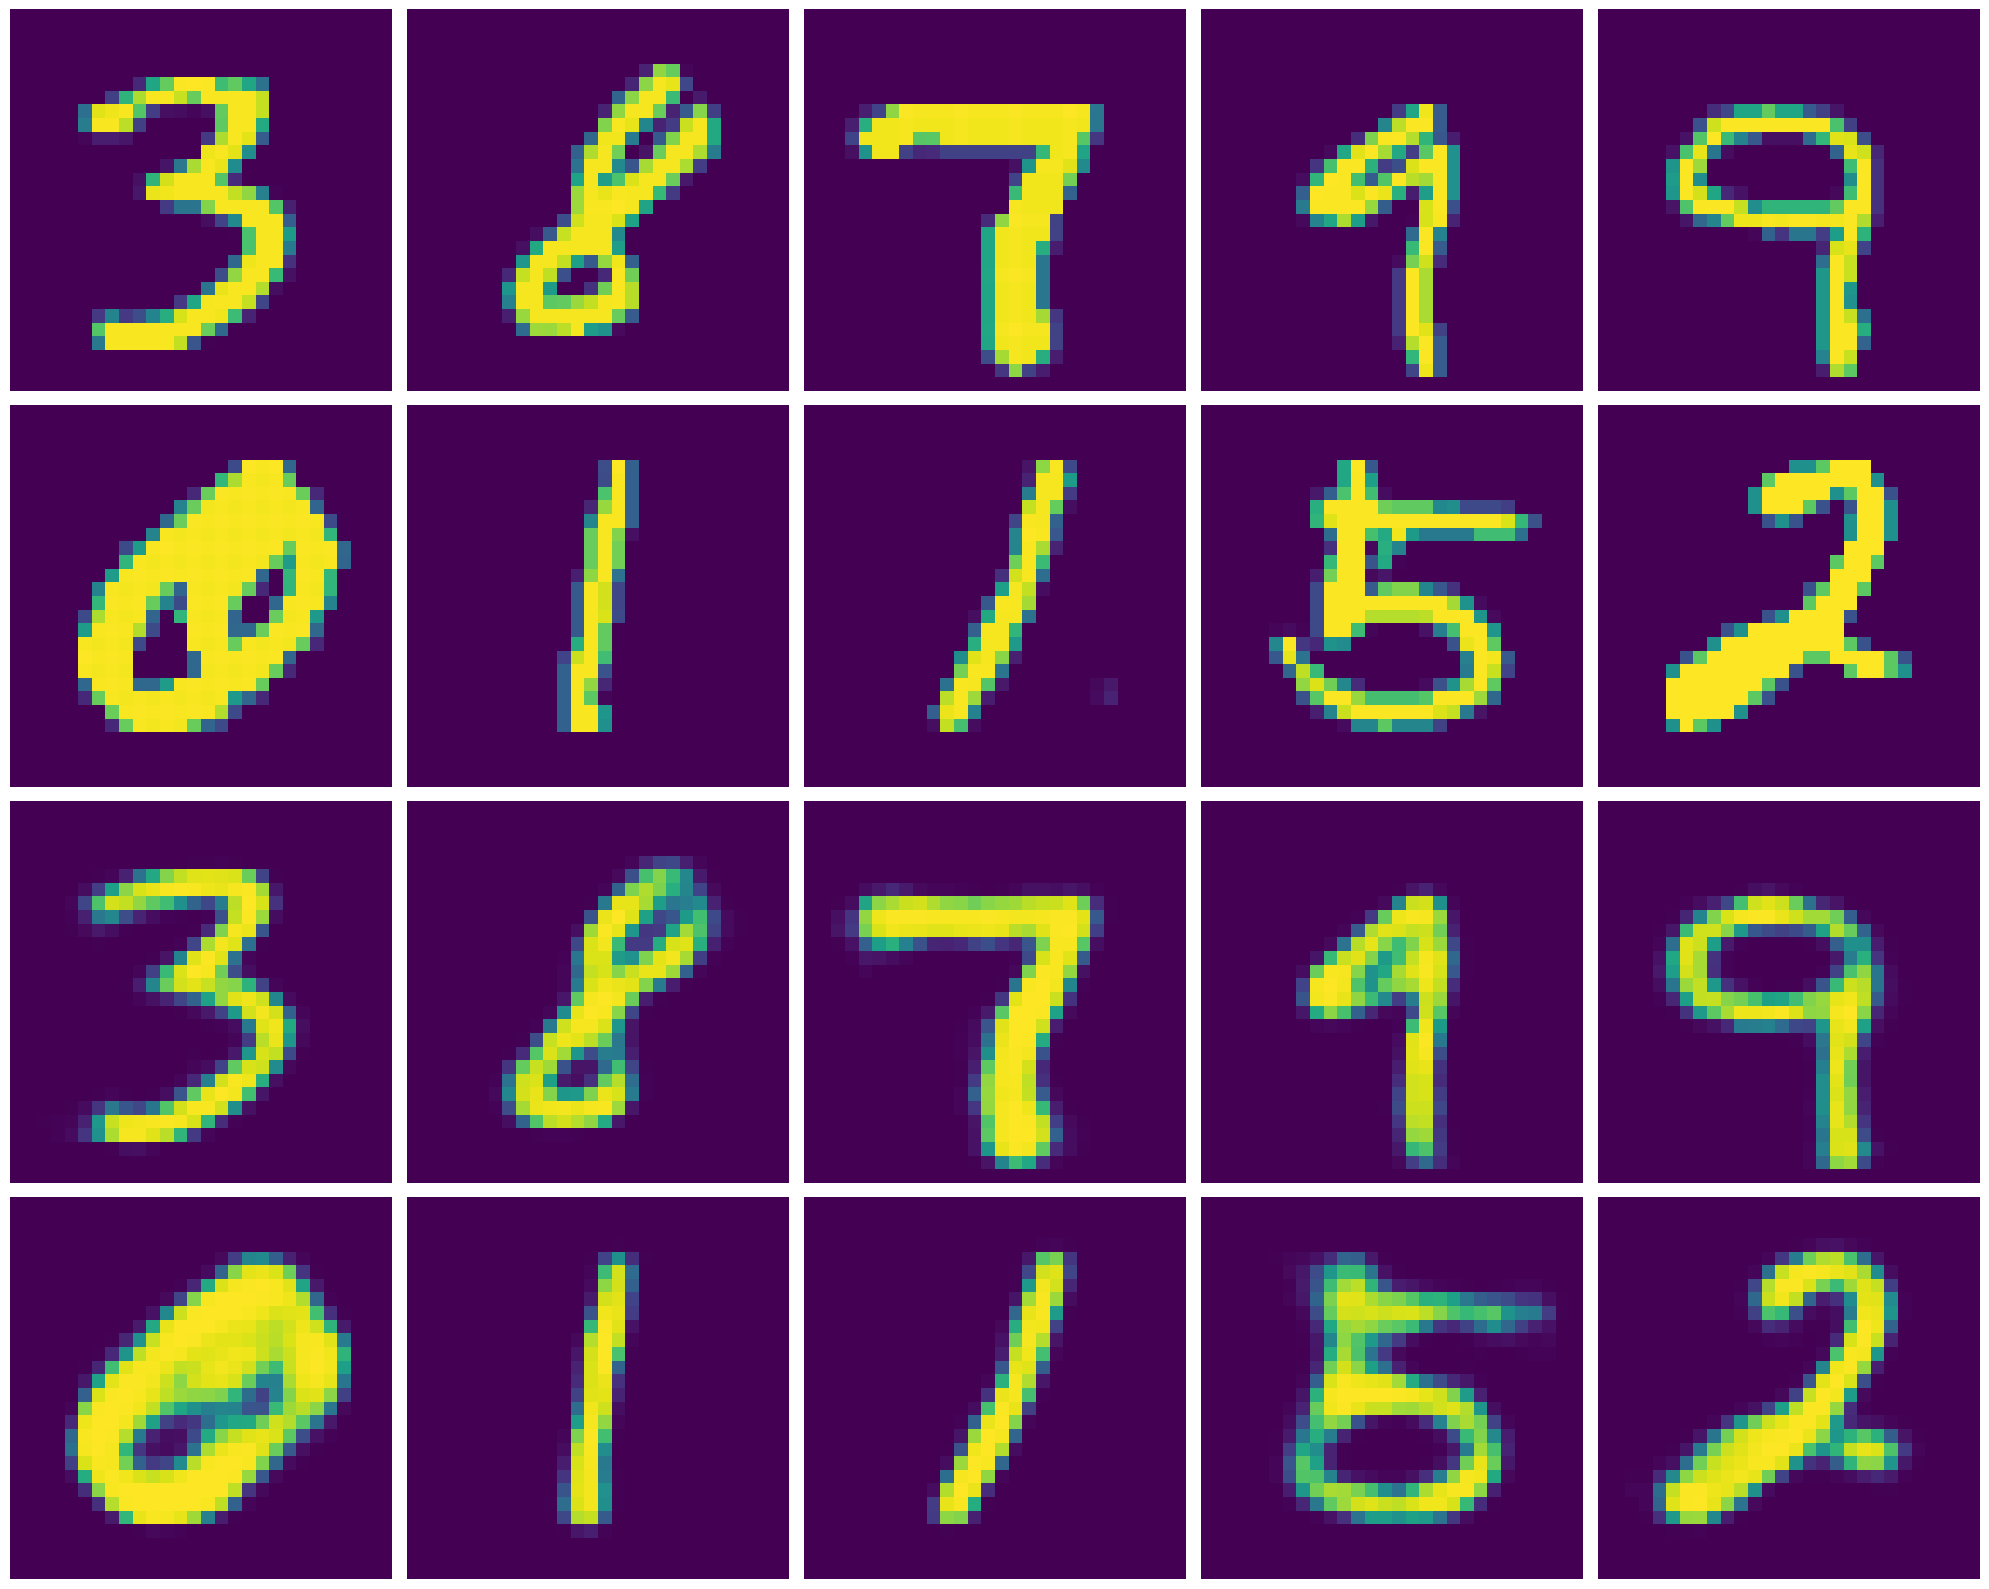

In [53]:
latent_dim = 20

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)